In [10]:
import pandas as pd
import numpy as np
import datetime as dt

from tensorflow import keras
import tensorflow as tf
from keras.utils import timeseries_dataset_from_array

import plotly.express as px
from sklearn.preprocessing import StandardScaler

### Importación de datos

Leemos el archivo y ordenamos por datetime

In [2]:
data_df = pd.read_csv('data_training/esios_data_modelo_dl.csv')
data_df = data_df.sort_values(by=['Datetime_hour']).reset_index(drop=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13872 entries, 0 to 13871
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Datetime_hour         13872 non-null  object 
 1   Gen.P48 Fotovoltaica  13872 non-null  float64
 2   MD                    13872 non-null  float64
 3   IDA1                  13872 non-null  float64
 4   IDA2                  13872 non-null  float64
 5   Gen.P48 Eolica        13872 non-null  float64
 6   Interconexiones P48   13872 non-null  float64
 7   Demanda P48           13872 non-null  float64
 8   Gen.P48 Total         13872 non-null  float64
dtypes: float64(8), object(1)
memory usage: 975.5+ KB


### Visualización inicial

Visualizamos la forma de la función target para las últimas 2 semanas

In [3]:
px.line(data_df.iloc[-3*24*7:], x='Datetime_hour', y='MD')

### Preparación de datos

Convertir dataframe en array

In [4]:
features = [col for col in data_df.columns if col not in ['Datetime_hour']]

data_array = data_df[features].values
data_array.shape

(13872, 8)

Reescalar los datos de entrenamiento

In [5]:
train_steps = int(0.5 * len(data_array))
val_steps = int(0.25 * len(data_array))
test_steps = len(data_array) - train_steps - val_steps

scaler = StandardScaler()
scaler.fit(data_array[:train_steps])   # fit sólo con la porción de entrenamiento
data_scaled = scaler.transform(data_array) 

Ventanas temporales

In [6]:
input_steps = 24*7
output_steps = 24

X, y = [], []

for i in range(len(data_scaled) - input_steps - output_steps):
    X.append(data_scaled[i:i+input_steps])
    y.append(data_scaled[i+input_steps:i+input_steps+output_steps, features.index('MD')])


X = np.array(X)
y = np.array(y)

Dividir en Train, Val, Test y crear datasets

In [12]:
num_train_samples = int(0.5*len(X))
num_val_samples = int(0.25*len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]

X_val = X[num_train_samples:num_train_samples + num_val_samples]
y_val = y[num_train_samples:num_train_samples + num_val_samples]

X_test = X[num_train_samples + num_val_samples:]
y_test = y[num_train_samples + num_val_samples:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (6840, 168, 8), Val: (3420, 168, 8), Test: (3420, 168, 8)


In [40]:
y_train

array([[ 0.80355586,  0.73707234,  0.67392492, ...,  1.81629758,
         1.48149708,  1.30420771],
       [ 0.73707234,  0.67392492,  0.60863286, ...,  1.48149708,
         1.30420771,  1.088315  ],
       [ 0.67392492,  0.60863286,  0.60005435, ...,  1.30420771,
         1.088315  ,  1.11405055],
       ...,
       [ 0.66606128,  0.4249096 ,  0.28002796, ...,  0.39917405,
         0.70609436,  0.91150221],
       [ 0.4249096 ,  0.28002796,  0.2118764 , ...,  0.70609436,
         0.91150221,  0.64175548],
       [ 0.28002796,  0.2118764 , -0.04857694, ...,  0.91150221,
         0.64175548,  0.47852534]])

In [11]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Calculo del error base

Tenemos que establecer un objetivo de precisión para nuestro modelo. Para ello, suponemos dos pronósticos iniciales:
1. El precio a la misma hora del día anterior
2. El precio a la misma hora y el mismo día de la semana anterior

Consideramos esta segunda posibilidad, debido a la gran diferencia que existe entre los precios en fin de semana y entre semana.

In [13]:
md_true = []
md_delay_week = []
md_delay_day = []

# Calculamos los targets para el dataset sin escalar
for i in range(len(data_array) - input_steps - output_steps):
    md_true.append(data_array[i+input_steps:i+input_steps+output_steps, features.index('MD')])
    # Delay de 7 dias
    md_delay_week.append(data_array[i+input_steps-24*7:i+input_steps+output_steps-24*7, features.index('MD')])
    # Delay de 1 dia
    md_delay_day.append(data_array[i+input_steps-24:i+input_steps+output_steps-24, features.index('MD')])


md_true = np.array(md_true)
md_delay_week = np.array(md_delay_week)
md_delay_day = np.array(md_delay_day)

print(f"MAE week-delay: {np.mean(np.abs(md_true - md_delay_week))}")
print(f"MAE day-delay: {np.mean(np.abs(md_true - md_delay_day))}")

MAE week-delay: 28.191819627192977
MAE day-delay: 18.685218079922034


### Modelo de Redes Neuronales Densas

In [22]:
inputs = keras.Input(shape=(input_steps, X_train.shape[-1]))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")

Epoch 1/30


214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6833 - mae: 0.6444 - val_loss: 1.0290 - val_mae: 0.8108
Epoch 2/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4961 - mae: 0.5455 - val_loss: 0.9635 - val_mae: 0.7636
Epoch 3/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4758 - mae: 0.5354 - val_loss: 0.8894 - val_mae: 0.7408
Epoch 4/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4475 - mae: 0.5161 - val_loss: 0.8641 - val_mae: 0.7273
Epoch 5/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4339 - mae: 0.5105 - val_loss: 0.8312 - val_mae: 0.7162
Epoch 6/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4125 - mae: 0.4938 - val_loss: 0.8183 - val_mae: 0.7100
Epoch 7/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4089 - mae: 0.4903 - val_loss: 0.8566 - val_mae: 0.7369
Epoch 8/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3993 - mae: 0.4839 - val_loss: 0.8698 - val_mae: 0.7419
Epoch 9/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3931 

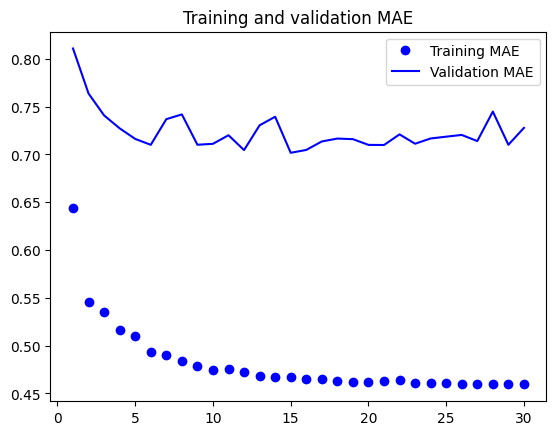

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Modelo RNN

In [30]:
inputs = keras.Input(shape=(input_steps, data_array.shape[-1]))
x = keras.layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.5640 - mae: 0.5939 - val_loss: 0.8256 - val_mae: 0.7314
Epoch 2/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.5178 - mae: 0.5604 - val_loss: 0.7876 - val_mae: 0.7074
Epoch 3/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.5057 - mae: 0.5513 - val_loss: 0.8857 - val_mae: 0.7669
Epoch 4/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.5002 - mae: 0.5488 - val_loss: 0.7930 - val_mae: 0.7130
Epoch 5/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.4977 - mae: 0.5463 - val_loss: 0.8684 - val_mae: 0.7580
Epoch 6/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.4929 - mae: 0.5429 - val_loss: 0.8052 - val_mae: 0.7186
Epoch 7/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.4911 - mae: 0.5427 - val_loss: 0.7806 - val_mae: 0.7032
Epoch 8/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.4881 - mae: 0.5404 - val_loss: 0.7993 - val_mae: 0.7162
Epoch 9/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/

In [31]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_ds)[1]:.2f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.8316 - mae: 0.7211
Test MAE: 0.72


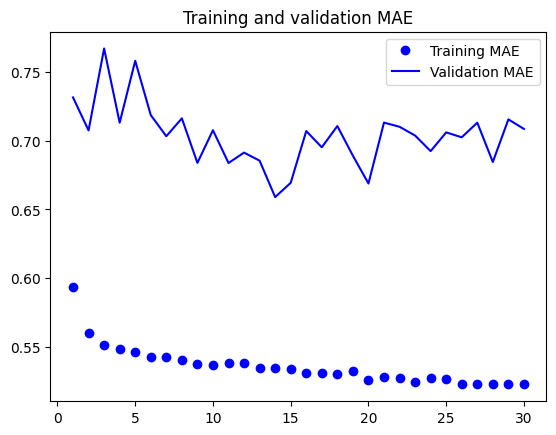

In [32]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [29]:
inputs = keras.Input(shape=(input_steps, data_array.shape[-1]))
x = keras.layers.GRU(16, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = keras.layers.GRU(16, recurrent_dropout=0.5)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_ds)[1]:.2f}")

Epoch 1/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 0.6062 - mae: 0.6196 - val_loss: 0.9571 - val_mae: 0.8040
Epoch 2/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 0.5402 - mae: 0.5784 - val_loss: 0.9104 - val_mae: 0.7766
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - loss: 0.5312 - mae: 0.5713 - val_loss: 0.9483 - val_mae: 0.7996
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - loss: 0.5198 - mae: 0.5616 - val_loss: 0.8954 - val_mae: 0.7692
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - loss: 0.5177 - mae: 0.5624 - val_loss: 0.9012 - val_mae: 0.7730
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - loss: 0.5164 - mae: 0.5600 - val_loss: 0.8885 - val_mae: 0.7681
Epoch 7/10
 48/214 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.2950 - mae: 0.4099

KeyboardInterrupt: 